# Bag-of-Words classification (JV)

Classification of publication day of week based on a Bag-of-Words analysis

In [3]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, clear_output

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import StratifiedKFold

from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score

## Training Data

For the Bag-of-Words and td-idf analysis, each document in the training data set is a concatenation of all of the hints for a particular puzzle, for a total of 9757 puzzles in the corpus.

In [4]:
xword_full = pd.read_csv('jv-xword-full.csv', converters={'Answer' : str, 'Hint' : str}, parse_dates = ['date'])

In [5]:
hints_per_puzzle = xword_full.groupby(['date'])['Hint'].agg(list).reset_index()
hints_per_puzzle['WeekdayNum'] = hints_per_puzzle['date'].dt.dayofweek
hints_per_puzzle['hints_joined'] = hints_per_puzzle['Hint'].apply(lambda x: " ".join(x))

hints_per_puzzle.sample(5)

,date,Hint,WeekdayNum,hints_joined
3408,2003-06-01,"[Garfield; for one, Dumas's Dantès, Strait of ...",6,Garfield; for one Dumas's Dantès Strait of ___...
1769,1998-11-29,"[Classic soft drink, Exaggerate, L.I.R.R. stop...",6,Classic soft drink Exaggerate L.I.R.R. stops I...
8750,2018-03-28,"[Cloths used to collect dust, ___ elephant, Ha...",2,Cloths used to collect dust ___ elephant Habit...
7332,2014-05-08,"[Pink-slips, Two- or three-striper; for short,...",3,Pink-slips Two- or three-striper; for short Ci...
2319,2000-06-04,"[Charge, Auricular, Feature, Environmental haz...",6,Charge Auricular Feature Environmental hazard;...


# Bag of Words

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

In [17]:
vectorizer = CountVectorizer()

X = vectorizer.fit_transform(hints_per_puzzle['hints_joined'])
y = np.array(hints_per_puzzle['WeekdayNum'])

print(X.shape)
print(y)

(9757, 73889)
[5 6 0 ... 1 2 3]


In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                 test_size = .2,
                                                 random_state = 514,
                                                 shuffle = True,
                                                 stratify = y)

## Truncated SVD

Looking at the explained variance, it's not really fair to restrict the analysis to the first two principal components. Sunday is well separated because the puzzles have more hints, but the rest of the week is not.

In [20]:
pipe = Pipeline([
    ('SVD', TruncatedSVD(n_components = 10))
])

fit = pipe.fit_transform(X)

print(tsvd.explained_variance_)

[31.1552247   9.06800958  7.28101544  5.61032368  4.26303215  3.5447786
  3.26876734  2.69260204  2.30851458  2.11631235]


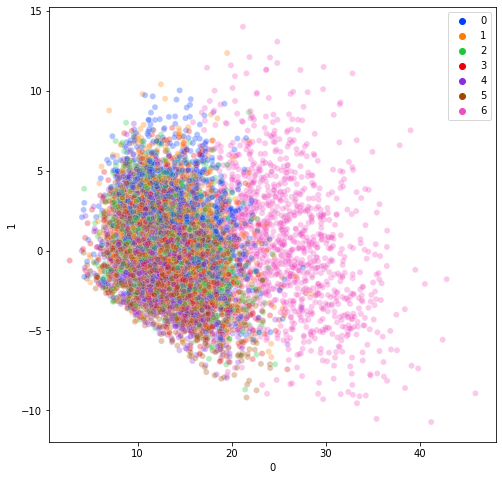

In [21]:
plt.figure(figsize=(8,8))

fit_df = pd.DataFrame(fit)
sns.scatterplot(data = fit_df, x = 0, y=1, hue=y, alpha=0.3, palette = 'bright')
plt.show()

## Feed Forward Network

In [22]:
%%time

mlp = MLPClassifier(hidden_layer_sizes=(10,40),max_iter=1000)

mlp.fit(X_train, y_train)

test_score = accuracy_score( y_test, mlp.predict(X_test) )
test_score

Wall time: 46.9 s


0.4334016393442623

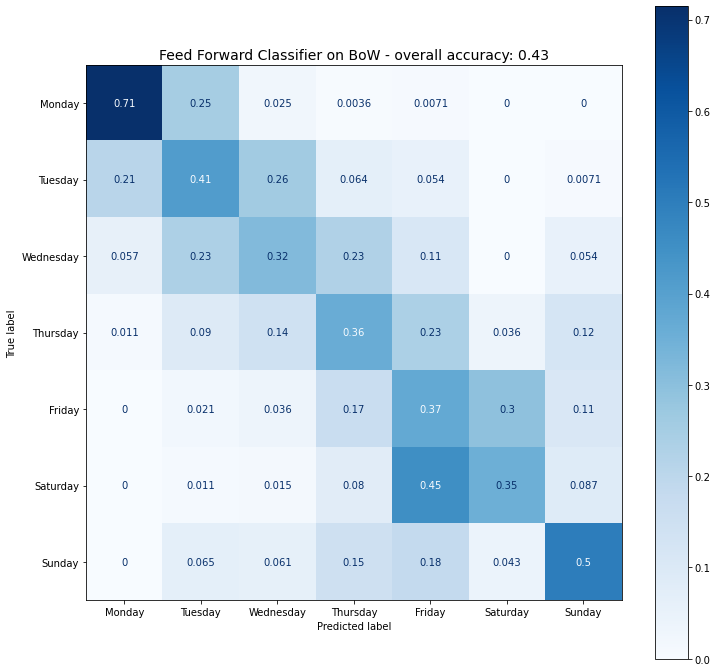

In [23]:
fig, ax = plt.subplots(figsize=(12,12))

disp = plot_confusion_matrix(mlp, X_test, y_test,
                                 display_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                                 cmap = plt.cm.Blues, 
                                 normalize = 'true', ax=ax)
disp.ax_.set_title('Feed Forward Classifier on BoW - overall accuracy: %.2f' % test_score, fontsize=14)
plt.show()

## SVM

In [31]:
%%time

kfold = StratifiedKFold(5, shuffle = True, random_state = 514)
c_vals = [0.5, 1.0, 2.0, 5.0]

accs1 = np.zeros((5, len(c_vals)))
accs2 = np.zeros((5, len(c_vals)))

i = 0
for train_index, test_index in kfold.split(X_train, y_train):
    X_train_CV, y_train_CV = X_train[train_index], y_train[train_index]
    X_test_CV, y_test_CV = X_train[test_index], y_train[test_index]
    
    clear_output(wait=True)
    display(f"i = {i}")
    
    for j,c in enumerate(c_vals):
        display('svm1')
        svm1 = LinearSVC(C=c, random_state=450)
        display('svm2')
        svm2 = SVC(kernel='linear', C=c, random_state=450)
        
        svm1.fit(X_train_CV, y_train_CV)
        svm2.fit(X_train_CV, y_train_CV)
        
        accs1[i,j] = accuracy_score( y_test_CV, svm1.predict(X_test_CV) )
        accs2[i,j] = accuracy_score( y_test_CV, svm2.predict(X_test_CV) )
    i += 1

'i = 4'

'svm1'

'svm2'

'svm1'

'svm2'

'svm1'

'svm2'

'svm1'

'svm2'

Wall time: 34min 48s


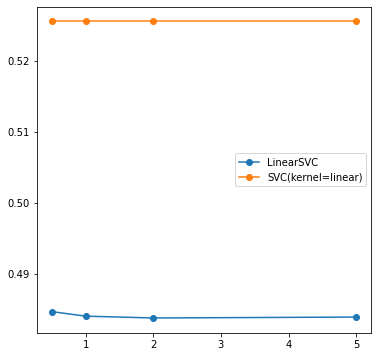

In [35]:
plt.figure(figsize=(6,6))
plt.plot(c_vals, np.mean(accs1, axis=0), 'o-', label='LinearSVC')
plt.plot(c_vals, np.mean(accs2, axis=0), 'o-', label='SVC(kernel=linear)')
plt.legend()
plt.show()

In [36]:
np.mean(accs2, axis=0)

array([0.52556054, 0.52556054, 0.52556054, 0.52556054])

In [37]:
svm = SVC(kernel='linear', random_state=450)
svm.fit(X_train, y_train)

SVC(kernel='linear', random_state=450)

In [40]:
test_score_svm = accuracy_score( y_test, svm.predict(X_test) )

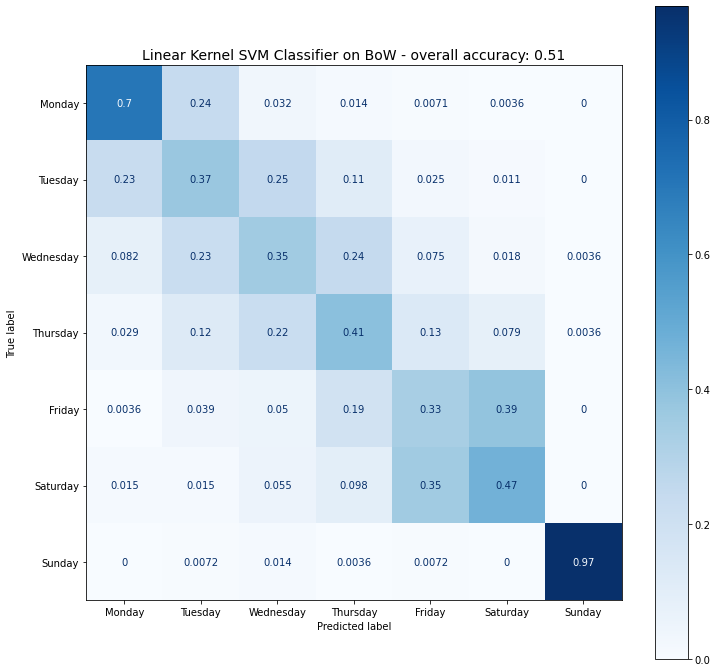

In [41]:
fig, ax = plt.subplots(figsize=(12,12))

disp = plot_confusion_matrix(svm, X_test, y_test,
                                 display_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                                 cmap = plt.cm.Blues, 
                                 normalize = 'true', ax=ax)
disp.ax_.set_title('Linear Kernel SVM Classifier on BoW - overall accuracy: %.2f' % test_score_svm, fontsize=14)
plt.show()

## Random Forest

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [52]:
kfold = StratifiedKFold(5, shuffle = True, random_state = 514)

# Maybe increase?
depths = range(1,41)

accs_rf = np.zeros((5, len(depths)))

i = 0
for train_index, test_index in kfold.split(X_train, y_train):
    X_train_CV, y_train_CV = X_train[train_index], y_train[train_index]
    X_test_CV, y_test_CV = X_train[test_index], y_train[test_index]
    
    for j,d in enumerate(depths):
        clear_output(wait=True)
        display(f'i = {i}, depth = {d}')
        
        forest_clf = RandomForestClassifier(max_depth = d, random_state=514)
        forest_clf.fit(X_train_CV, y_train_CV)
        
        accs_rf[i,j] = accuracy_score( y_test_CV, forest_clf.predict(X_test_CV) )
    
    i += 1

'i = 4, depth = 40'

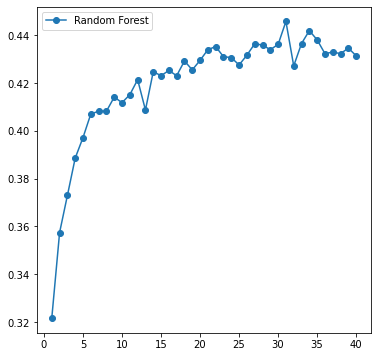

In [53]:
plt.figure(figsize=(6,6))
plt.plot(depths, np.mean(accs_rf, axis=0), 'o-', label='Random Forest')
plt.legend()
plt.show()

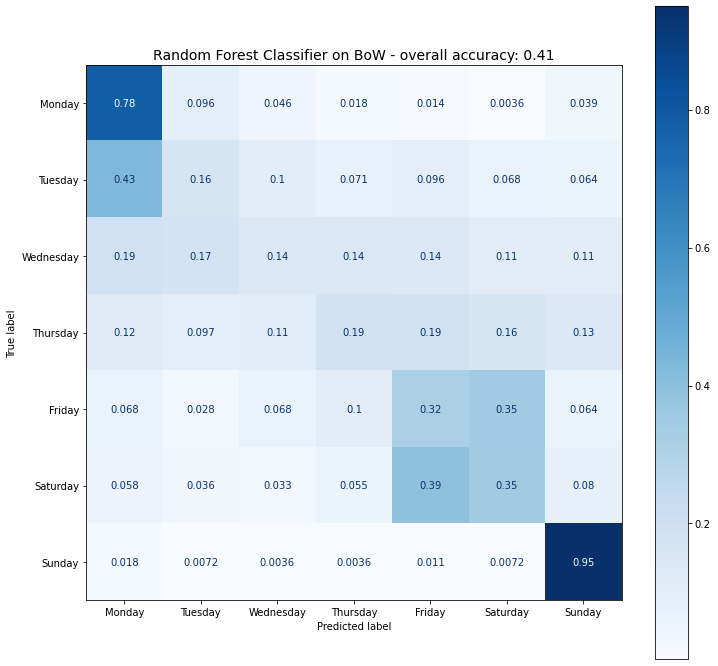

In [56]:
forest_clf = RandomForestClassifier(max_depth = 22, random_state=514)
forest_clf.fit(X_train, y_train)
test_score_rf = accuracy_score( y_test, forest_clf.predict(X_test) )

fig, ax = plt.subplots(figsize=(12,12))

disp = plot_confusion_matrix(forest_clf, X_test, y_test,
                                 display_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                                 cmap = plt.cm.Blues, 
                                 normalize = 'true', ax=ax)
disp.ax_.set_title('Random Forest Classifier on BoW - overall accuracy: %.2f' % test_score_rf, fontsize=14)
plt.show()

## Boosted Decision Tree

In [46]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [50]:
%%time

depths = range(1, 11)
estimators = range(1,16)
learning_rate = 0.5

accs_boost = np.zeros((len(estimators), len(depths)))

for i, n in enumerate(estimators):
    for j, d in enumerate(depths):
        clear_output(wait=True)
        display(f'estimator = {n} depth = {d}')
        
        ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=d),
                    n_estimators = n,
                    algorithm="SAMME.R",
                    learning_rate = learning_rate
                                    )
        
        ada_clf.fit(X_train, y_train)
        accs_boost[i,j] = accuracy_score( y_test, ada_clf.predict(X_test) )

'estimator = 15 depth = 10'

Wall time: 22min 2s


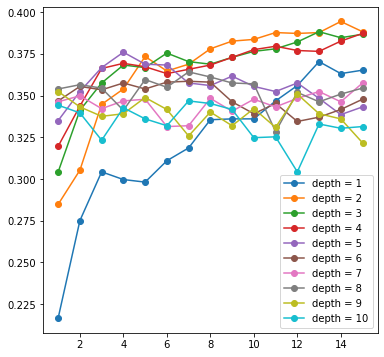

In [51]:
plt.figure(figsize=(6,6))
for d in depths:
    plt.plot(estimators, accs_boost[:,d-1], 'o-', label=f'depth = {d}')
plt.legend()
plt.show()

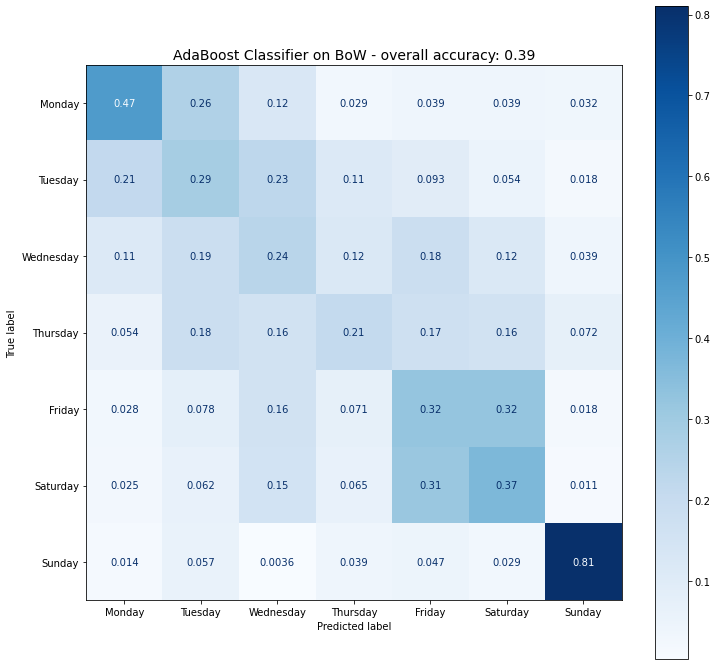

In [58]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),
                    n_estimators = 11,
                    algorithm="SAMME.R",
                    learning_rate = learning_rate
                                    )
ada_clf.fit(X_train, y_train)
test_score_boost = accuracy_score( y_test, ada_clf.predict(X_test) )

fig, ax = plt.subplots(figsize=(12,12))

disp = plot_confusion_matrix(ada_clf, X_test, y_test,
                                 display_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                                 cmap = plt.cm.Blues, 
                                 normalize = 'true', ax=ax)
disp.ax_.set_title('AdaBoost Classifier on BoW - overall accuracy: %.2f' % test_score_boost, fontsize=14)
plt.show()